# Human Bone Marrow from Oetjen et al.

Here we analyse sample A from [Oetjen at al.](https://insight.jci.org/articles/view/124928) (from a healthy donor) (v2 chemistry) (Cell Ranger 2.0.0).
Dataset on GEO: [GSM3396161](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3396161)

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
#import preprocessing as scIBpp

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.4+40.gbd5f862 anndata==0.6.22.post1 umap==0.3.9 numpy==1.15.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
# install some R packages through rpy2 (the rest are installed via conda)
packnames = ('RColorBrewer', 'gam', 'ggplot2', 'plyr')
from rpy2.robjects.vectors import StrVector
#utils.install_packages(StrVector(packnames))
results_file = './write/Oet_BM_A_1.h5ad'  # the file that will store the analysis results

In [4]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
#library(slingshot)
#library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

In [5]:
## Load previously processed dataset
#adata = sc.read_h5ad(results_file)

In [5]:
# Set up data loading
file_base = '../Munich/datasets/human/BoneMarrow_Oetjen/GSE120221_RAW/GSM3396161_'
data_file_end = 'matrix_A.mtx.gz'
barcode_file_end = 'barcodes_A.tsv.gz'
gene_file_end = 'genes_A.tsv.gz'

In [6]:
# Data set load & annotation
#Parse Filenames
data_file = file_base+data_file_end
barcode_file = file_base+barcode_file_end
gene_file = file_base+gene_file_end

#Load data
adata = sc.read(data_file, cache=True)
adata = adata.transpose()
adata.X = adata.X.toarray()

barcodes = pd.read_csv(barcode_file, header=None, sep='\t')
genes = pd.read_csv(gene_file, header=None, sep='\t')

#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes

genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata.var = genes

... reading from cache file cache/..-Munich-datasets-human-BoneMarrow_Oetjen-GSE120221_RAW-GSM3396161_matrix_A.h5ad


In [7]:
adata

AnnData object with n_obs × n_vars = 2994 × 33694 
    var: 'gene_id'

In [8]:
adata.var.head()

,gene_id
gene_symbol,
RP11-34P13.3,ENSG00000243485
FAM138A,ENSG00000237613
OR4F5,ENSG00000186092
RP11-34P13.7,ENSG00000238009
RP11-34P13.8,ENSG00000239945


In [9]:
adata.var_names_make_unique()

In [10]:
# Checking the total size of the data set
adata.shape

(2994, 33694)

# 1. Pre-processing and visualization

## 1.1 Quality control

In [11]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

In [12]:
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']


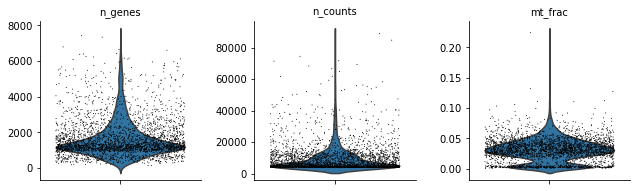

In [13]:
# Quality control - plot QC metrics
sc.pl.violin(adata, ['n_genes', 'n_counts', 'mt_frac'],
             jitter=0.4, multi_panel=True)

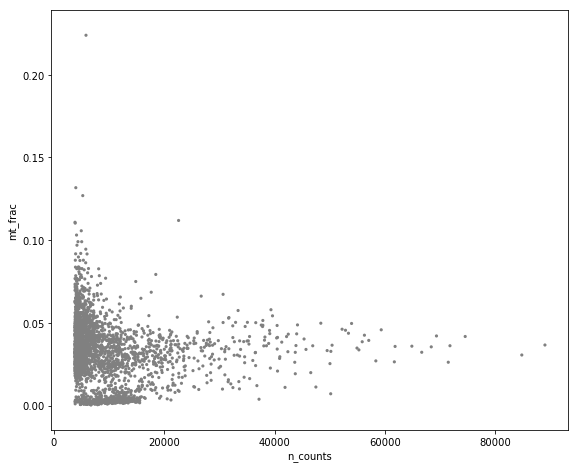

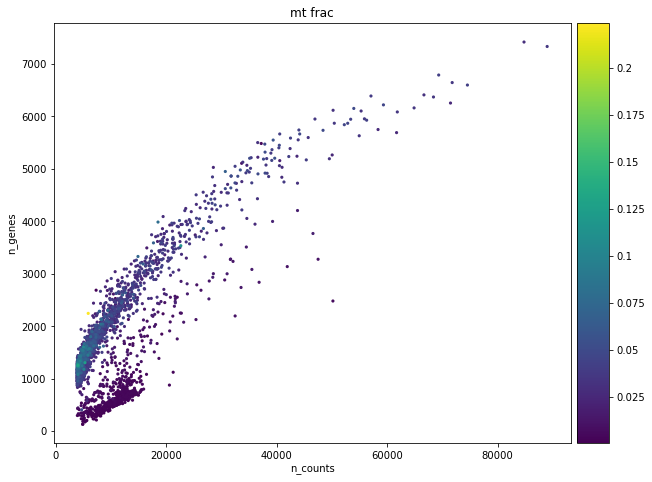

In [14]:
sc.pl.scatter(adata, x='n_counts', y='mt_frac')
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')

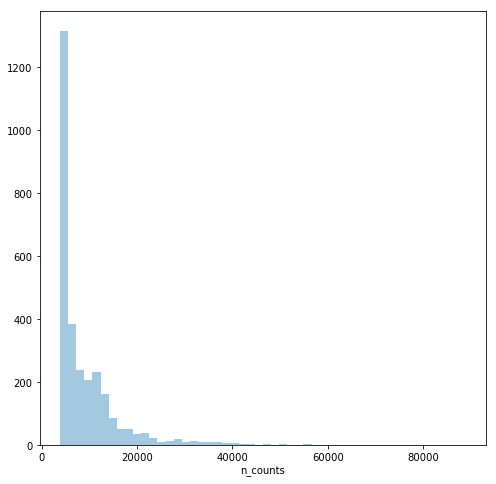

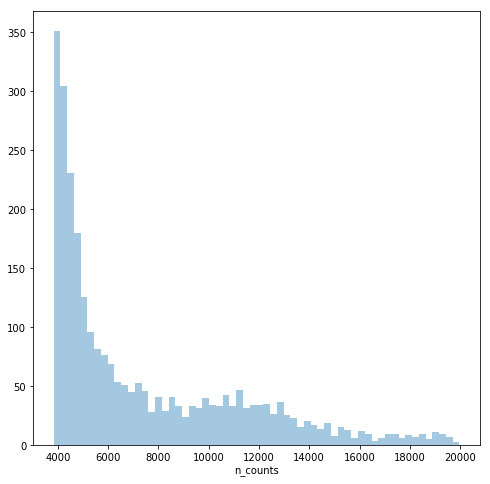

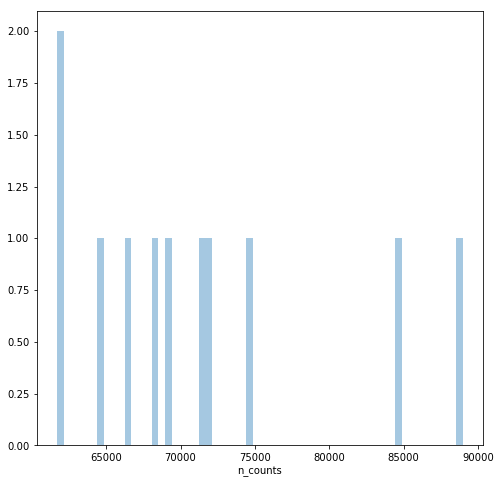

In [15]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<20000], kde=False, bins=60)
plt.show()

p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>60000], kde=False, bins=60)
plt.show()

Zoom-in histograms of the number of counts per cell show that there's a big group of cells with n_counts < 6000. We will tackle this issue looking at the number of genes. On the upper end of the distribution, we can filter out those 2 cells with n_counts > 80000.

In [16]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 80000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))


Total number of cells: 2994
filtered out 2 cells that havemore than 80000 counts
Number of cells after max count filter: 2992
Number of cells after MT filter: 2991


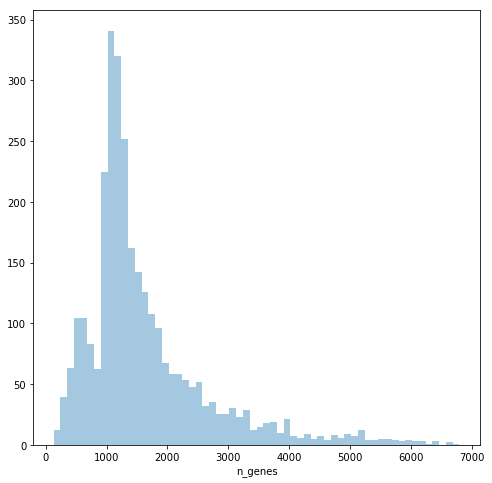

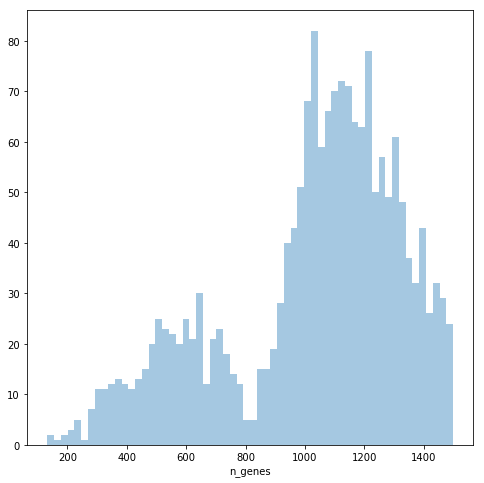

In [17]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1500], kde=False, bins=60)
plt.show()



From the histograms of the number of genes per cell, we can notice that there still is a small population showing n_genes < 800 which should be filtered out.

In [18]:
# Thresholding on number of genes
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 800)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 2991
filtered out 405 cells that haveless than 800 genes expressed


Trying to set attribute `.obs` of view, making a copy.


Number of cells after gene filter: 2586


In [19]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 33694
filtered out 20931 genes that are detectedin less than 20 cells
Number of genes after cell filter: 12763


## 1.2 Normalization

In [20]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 15
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)


In [21]:
# Check if the minimum number of cells per cluster is < 21:in that case, sizes will be also passed as input to the normalization
adata_pp.obs['groups'].value_counts()

0     598
1     484
2     361
3     277
4     195
5     167
6     124
7     113
8     104
9      64
10     58
11     41
Name: groups, dtype: int64

In [22]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [23]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [24]:
#Delete adata_pp
del adata_pp

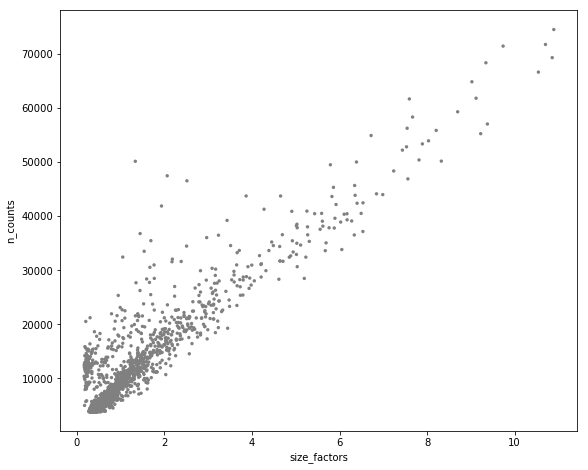

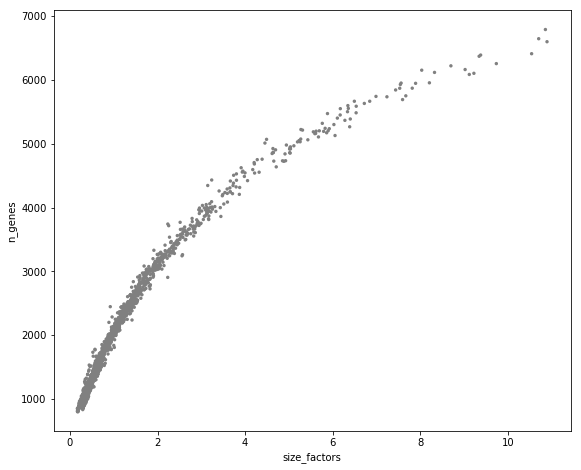

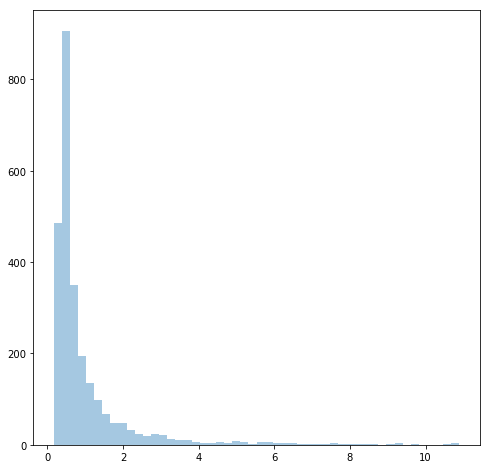

In [25]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [26]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [27]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [28]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

## 1.3 Highly variable genes

In [29]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


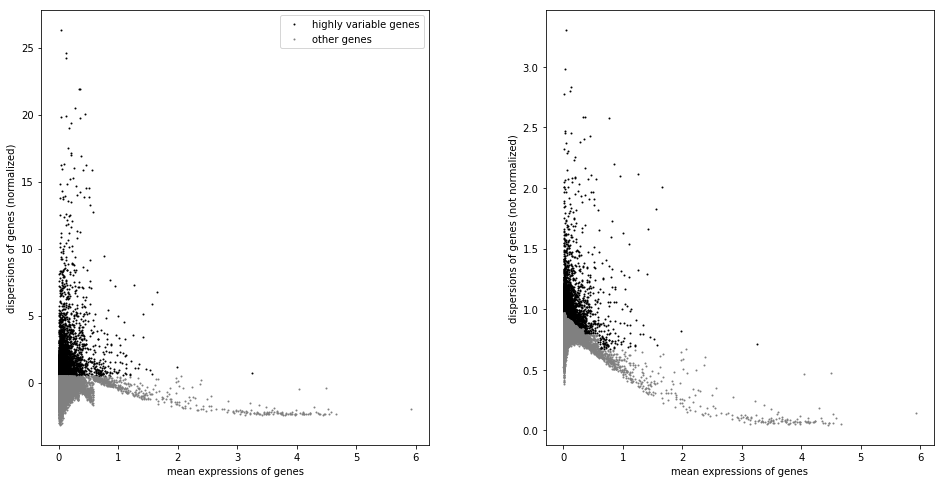

In [30]:
sc.pl.highly_variable_genes(adata)

# 2. Visualization

In [31]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99717075 0.9952949  0.99413574 0.99295986 0.9926154
     0.9913622  0.98868    0.9875566  0.9863376  0.9811915  0.9797407
     0.97814643 0.96710783 0.96121424]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:21)


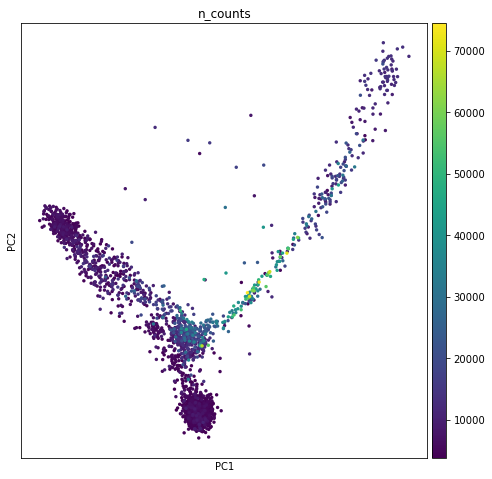

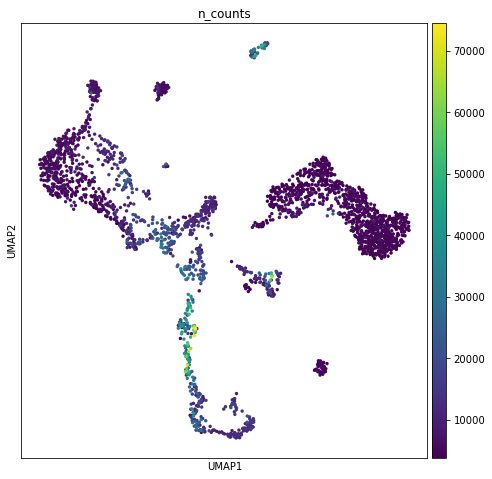

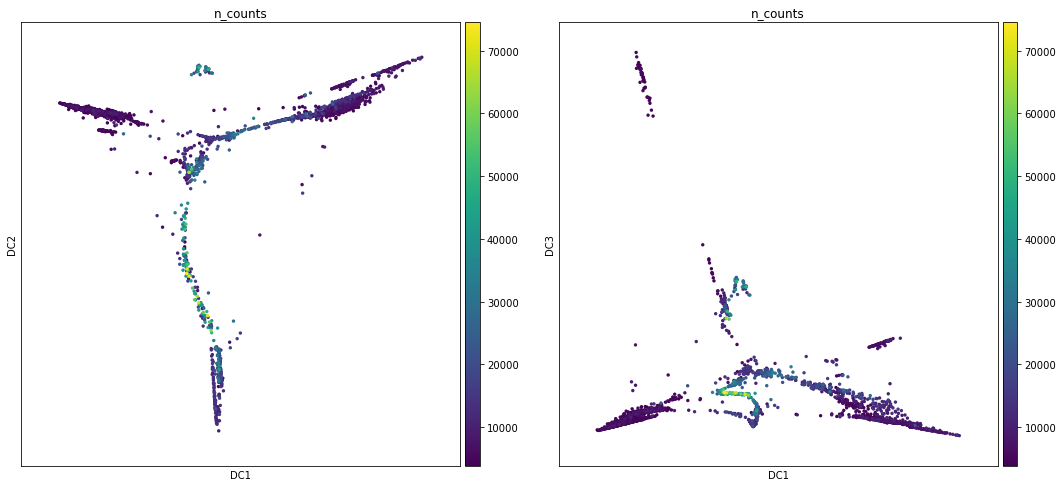

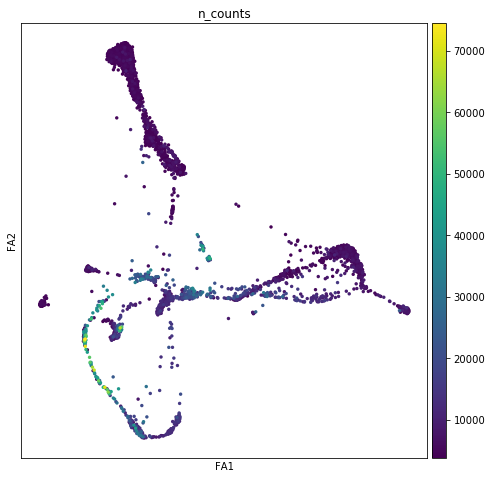

In [32]:
sc.pl.pca_scatter(adata, color='n_counts')
sc.pl.umap(adata, color='n_counts')
sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'])
sc.pl.draw_graph(adata, color='n_counts')

In [33]:
adata.write(results_file)

# 3. Clustering

In [34]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5', random_state=10)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical) (0:00:00)


In [35]:
adata.obs['louvain_r0.5'].value_counts()

0     672
1     412
2     365
3     288
4     184
5     180
6     115
7      91
8      88
9      61
10     54
11     43
12     33
Name: louvain_r0.5, dtype: int64

In [36]:
adata.obs['louvain_r1'].value_counts()

0     546
1     389
2     350
3     227
4     183
5     124
6     112
7      94
8      92
9      91
10     89
11     72
12     61
13     54
14     43
15     33
16     26
Name: louvain_r1, dtype: int64

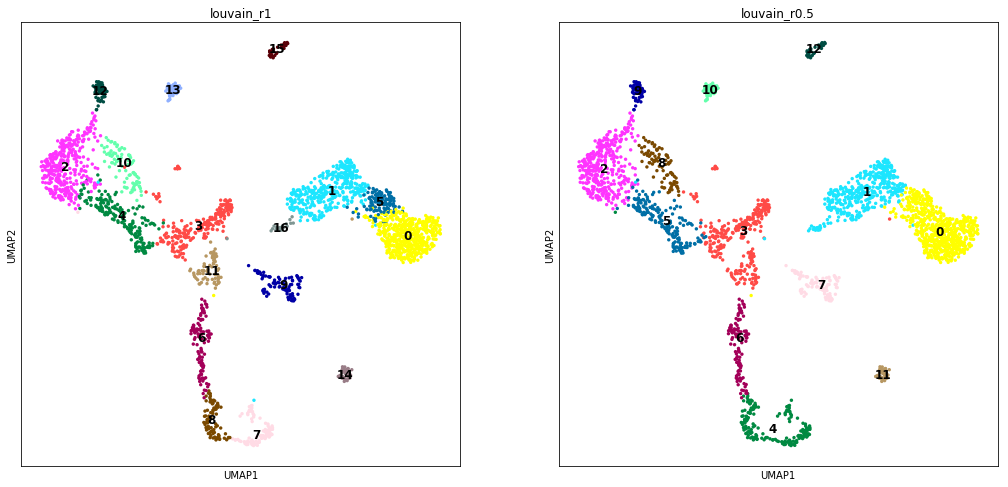

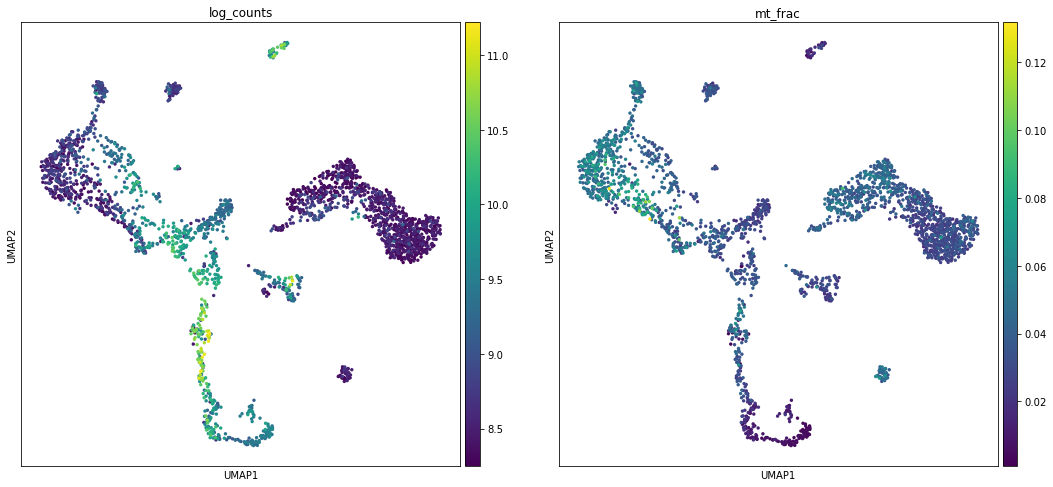

In [37]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1', 'louvain_r0.5'], palette=sc.pl.palettes.default_64, legend_loc='on data', legend_fontsize=12)
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])



# 4. Marker genes and cluster annotation (r 1)

In [45]:
#Calculate marker genes r1
sc.tl.rank_genes_groups(adata, groupby='louvain_r1', key_added='rank_genes_r1')

ranking genes
    finished: added to `.uns['rank_genes_r1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


## 4.1 List of markers of cell types from PanglaoDB
Here we use a list of markers for 34 different cell types from PanglaoDB, considering all cell types in "immune system" + "blood" + "bone". We manually checked that all cell types were possible for healthy tissue, so we excluded:
* __Myeloid derived suppressor cells__, description: MDSC are not present at steady state in healthy individuals and appear in cancer and pathological conditions associated with chronic inflammation or stress. 
* __Red pulp macrophages__, description: Present in the red pulp of the spleen. They are necessary for maintaining blood homeostasis by performing phagocytosis upon injured and senescent erythrocytes and blood-borne particulates.

In [38]:
markers_df = pd.read_csv('../Munich/Immune_markers_PanglaoDB.txt', delimiter='\t')
markers_df.shape

(2089, 14)

In [39]:
markers_df = markers_df[markers_df['cell.type'] != 'Myeloid-derived suppressor cells']
markers_df.shape

(2072, 14)

In [40]:
markers_df = markers_df[markers_df['cell.type'] != 'Red pulp macrophages']
markers_df.shape

(2060, 14)

In [41]:
# Select only human markers
markers_df_hum = markers_df[(markers_df['species'] == 'Hs') | (markers_df['species'] == 'Mm Hs')]
markers_df_hum.shape

(1907, 14)

In [42]:
cell_types = list(markers_df_hum['cell.type'].unique())

In [43]:
markers_dict = {}
for ctype in cell_types:
    df = markers_df_hum[markers_df_hum['cell.type'] == ctype]
    markers_dict[ctype] = df['official.gene.symbol'].to_list()

In [46]:
cell_annotation = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r1')

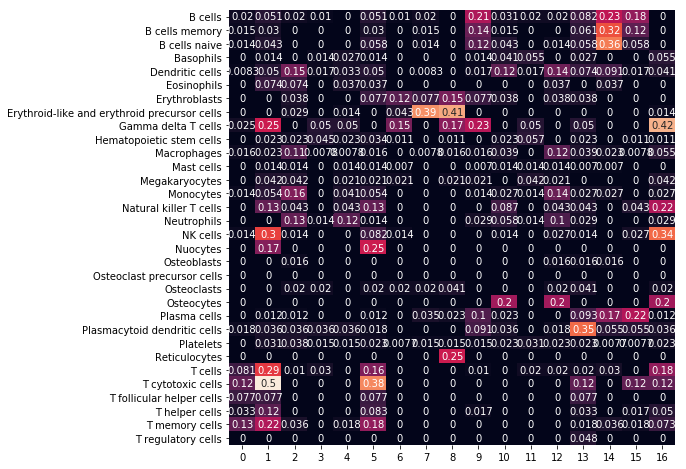

In [47]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r1', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

In [49]:
# Categories to rename
adata.obs['cell_type1'] = adata.obs['louvain_r1']
adata.rename_categories('cell_type1', ['T cells, 1', 'T+NK, 1', 'Monocytes, 1', 'Unknown, 1', 'Unknown, 2', 'T cells, 2', 'Erytro, 1', 'Erytro, 2', 'Erytro, 3', 'B cells, 2', 'Osteocytes, 1', 'Unknown, 3', 'Osteocytes, 2', 'Plasmacytoid dendritic cells', 'B cells, 1', 'Plasma cells', 'NK'])

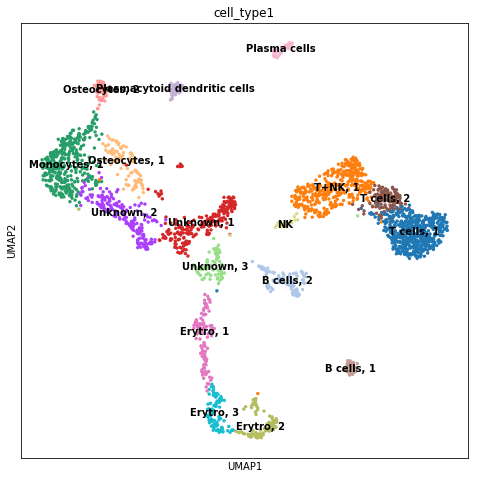

In [50]:
sc.pl.umap(adata, color='cell_type1', legend_loc='on data')

In [51]:
adata.write(results_file)

# 5. Plot makers of subtypes

In [53]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

## T cells

We want to annotate CD8+ versus CD4+ cells.
For the labels to be consistent with the MCA-derived, we check the expression of those markers as well (when possible).

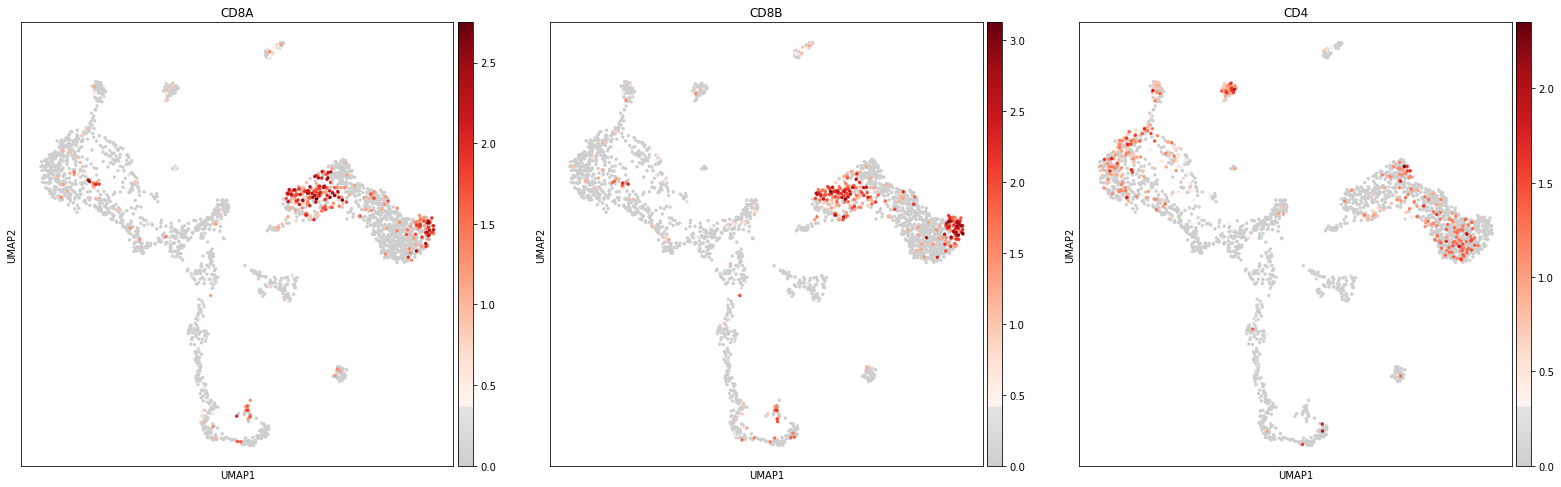

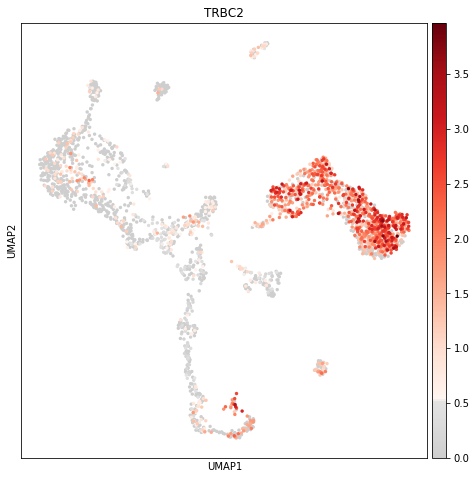

In [55]:
#Canonical markers
sc.pl.umap(adata, color=['CD8A','CD8B', 'CD4'], use_raw=False, color_map=mymap)

# Markers from MCA
sc.pl.umap(adata, color=['TRBC2'], use_raw=False, color_map=mymap)

We need to subcluster cluster 0 to annotate CD4+ vs CD8+ cells. 

## NK cells

We consider NK cells as CD8- CD4-. NKT cells are instead CD8+/CD4+ and NKG7/GZMA +.

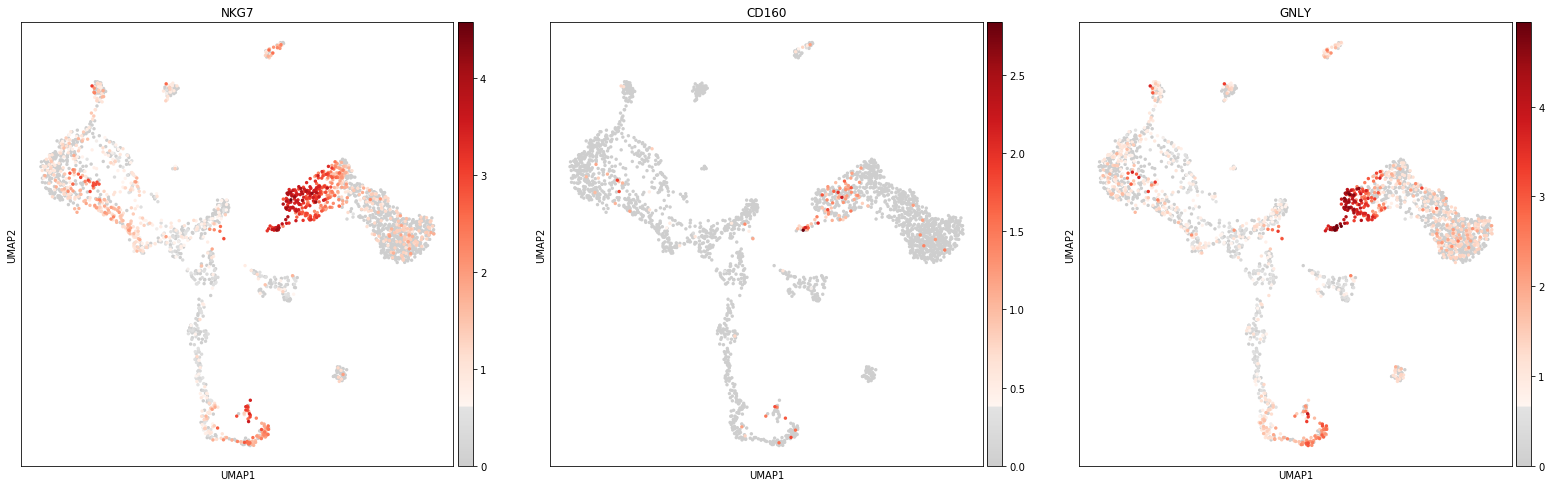

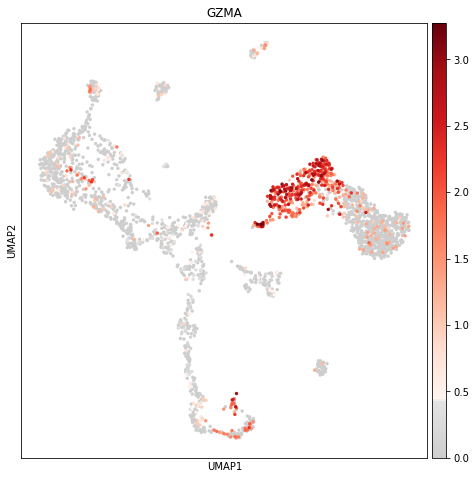

In [56]:
sc.pl.umap(adata, color=['NKG7','CD160', 'GNLY'], use_raw=False, color_map=mymap)

# marker from MCA
sc.pl.umap(adata, color=['GZMA'], use_raw=False, color_map=mymap)

Cluster 16 is NK cells, cluster 1 is NKT cells.

## Monocytes: CD14+ and CD16+

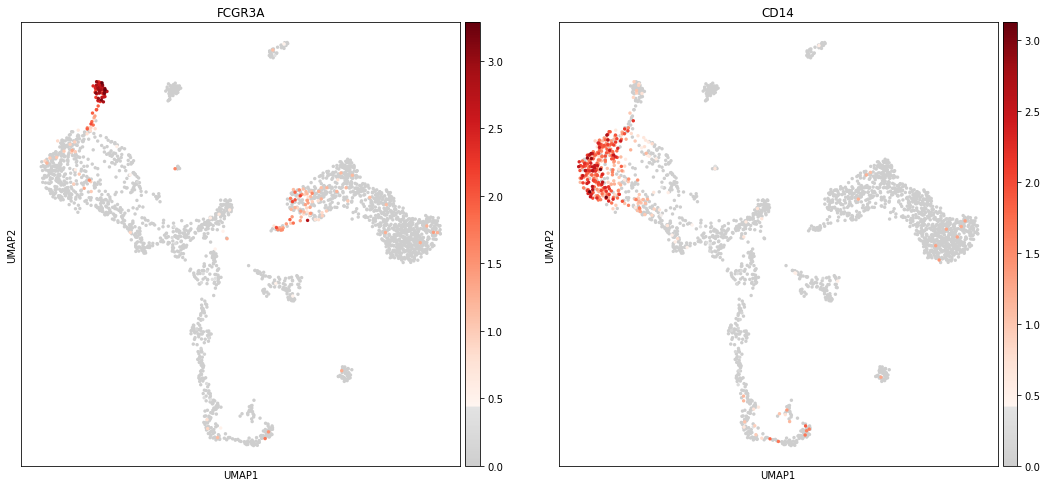

In [60]:
sc.pl.umap(adata, color=['FCGR3A','CD14'], use_raw=False, color_map=mymap)

Cluster 12 is CD16+, cluster 2 is CD14+. 

## Monocytes progenitors

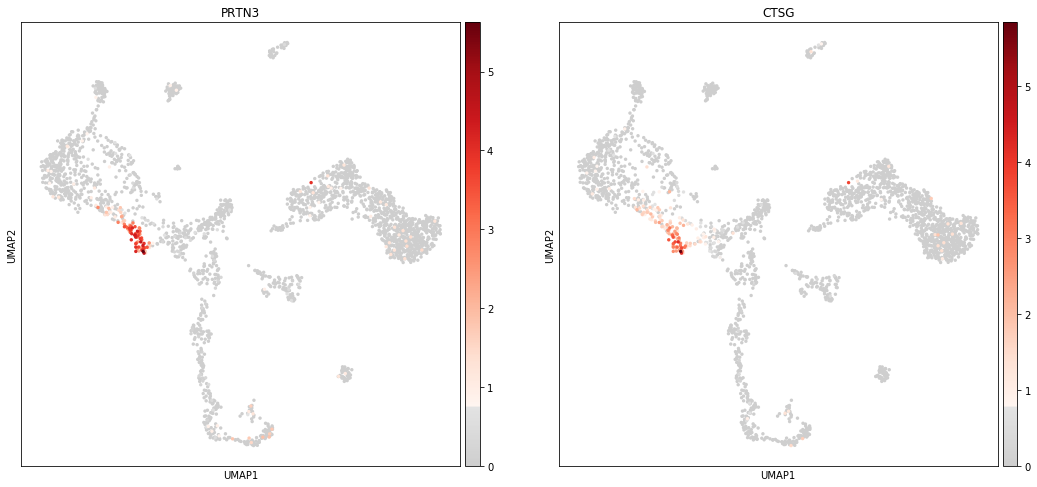

In [58]:
# Markers from MCA
sc.pl.umap(adata, color=['PRTN3','CTSG'], use_raw=False, color_map=mymap)

## Monocyte-derived Dendritic cells

Here we use markers from [Sinha et al.](https://www.ncbi.nlm.nih.gov/pubmed/29361178)

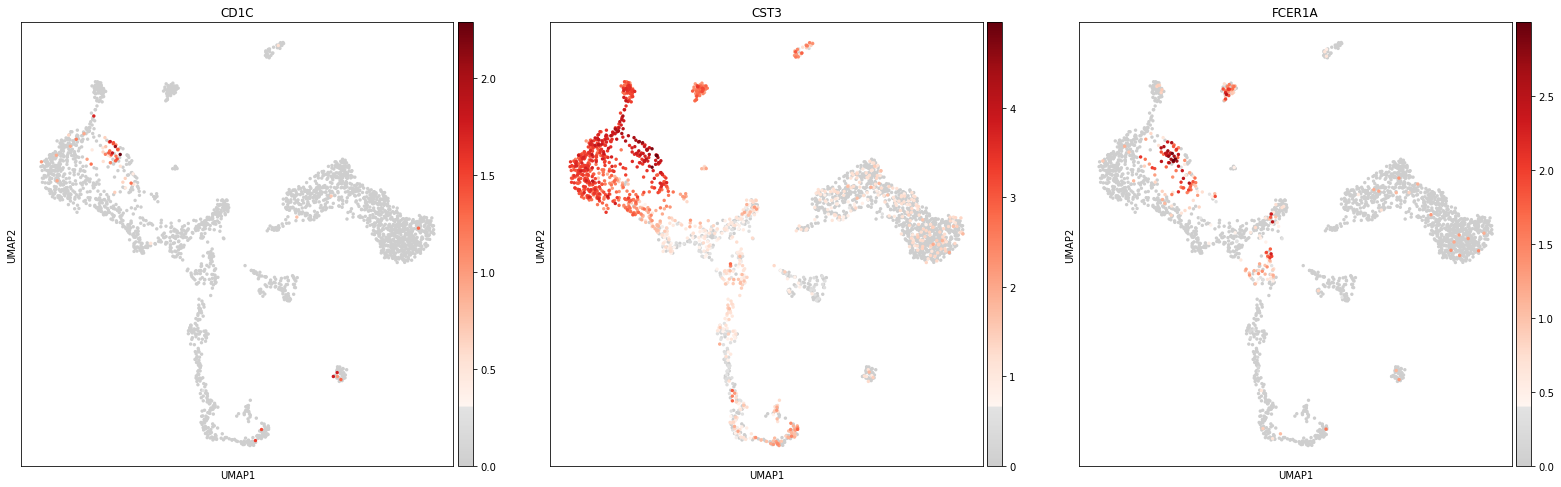

In [62]:
sc.pl.umap(adata, color=['CD1C', 'CST3', 'FCER1A'], use_raw=False, color_map=mymap)

## Plasmacytoid dendritic cells

Here we use markers from [Sinha et al.](https://www.ncbi.nlm.nih.gov/pubmed/29361178)

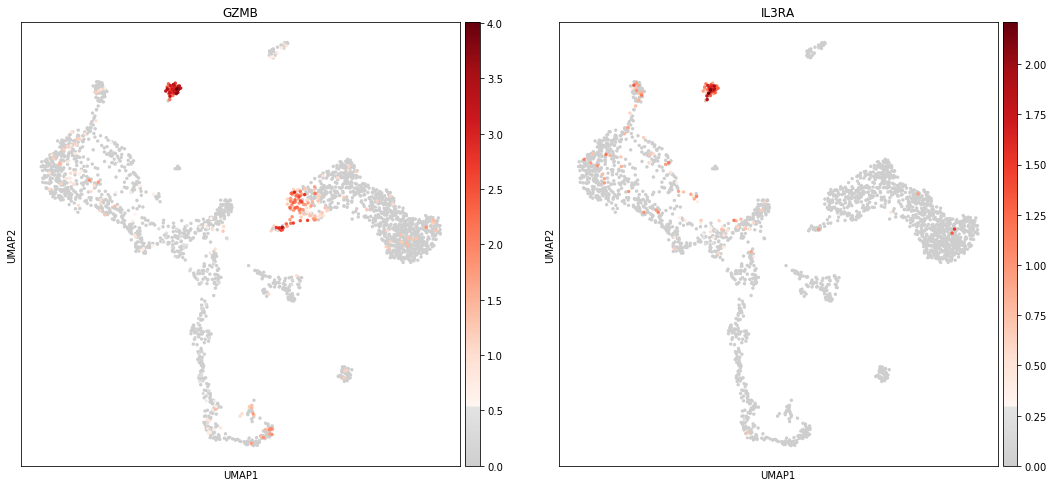

In [63]:
sc.pl.umap(adata, color=['GZMB', 'IL3RA'], use_raw=False, color_map=mymap)

## B cells

Oetjen et al. annotates B cells as CD20+ (MS4A1) or CD10+ (MME).


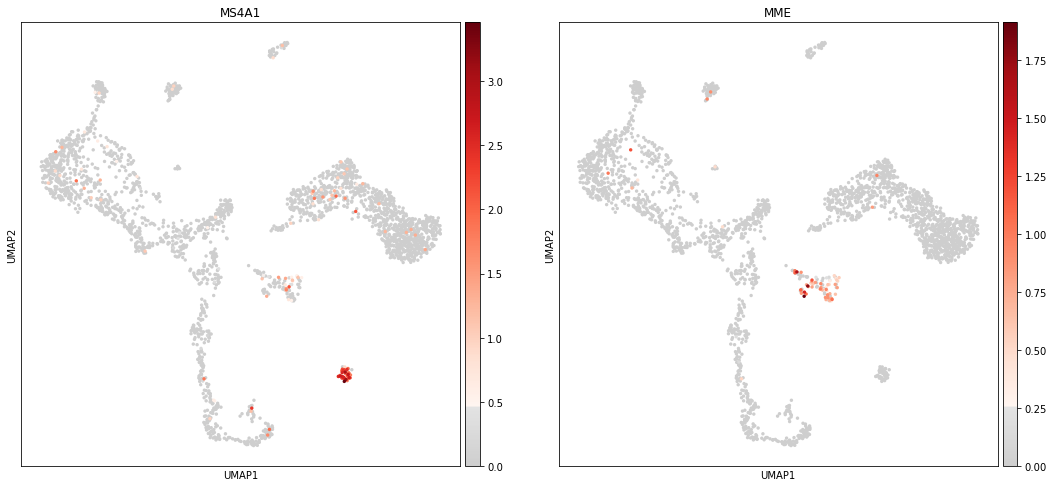

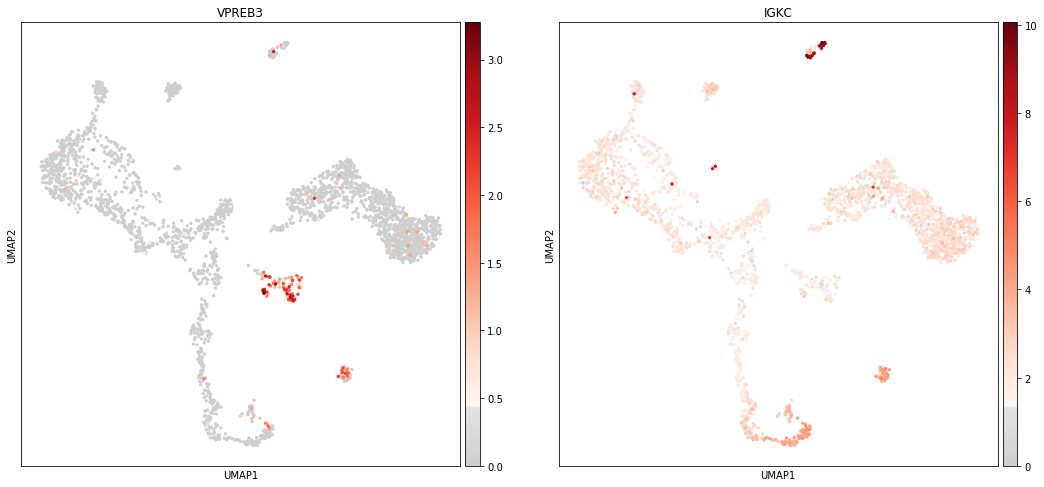

In [70]:
# Oetjen
sc.pl.umap(adata, color=['MS4A1', 'MME'], use_raw=False, color_map=mymap)

# markers from MCA
sc.pl.umap(adata, color=['VPREB3', 'IGKC'], use_raw=False, color_map=mymap)

## Hematopoietic stem progenitors cells (HSPCs)

Using markers from [CellMarker](http://biocc.hrbmu.edu.cn/CellMarker/search.jsp?quickSearchInfo=bone%20marrow)

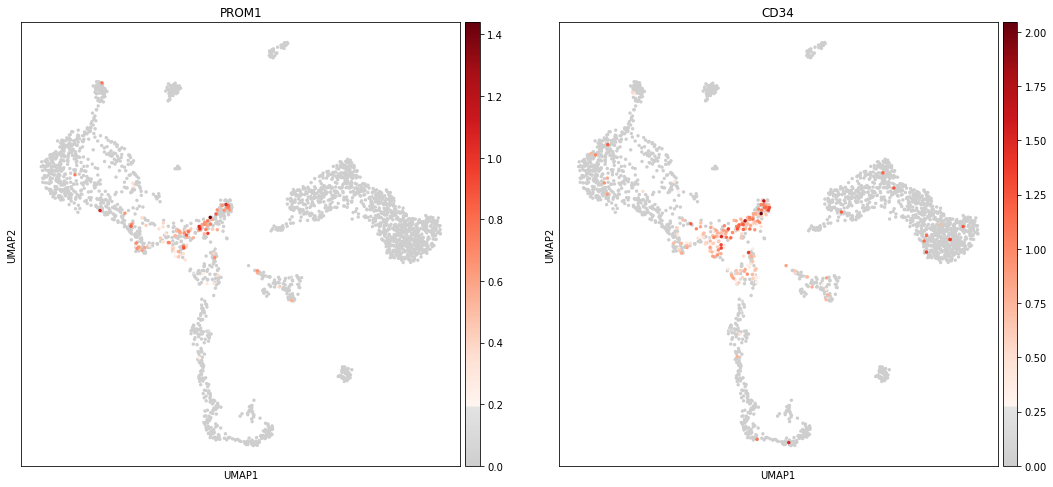

In [113]:
sc.pl.umap(adata, color=['PROM1', 'CD34'], use_raw=False, color_map=mymap)

## Erythrocytes

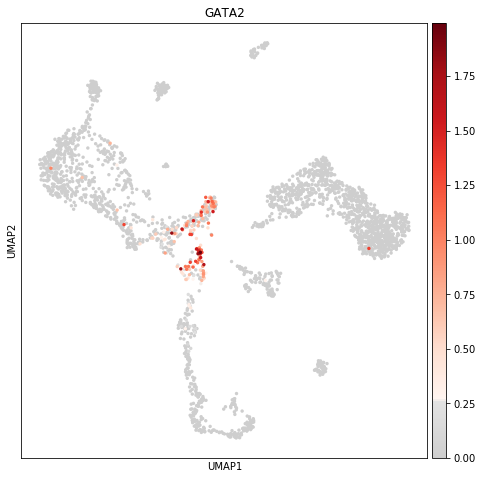

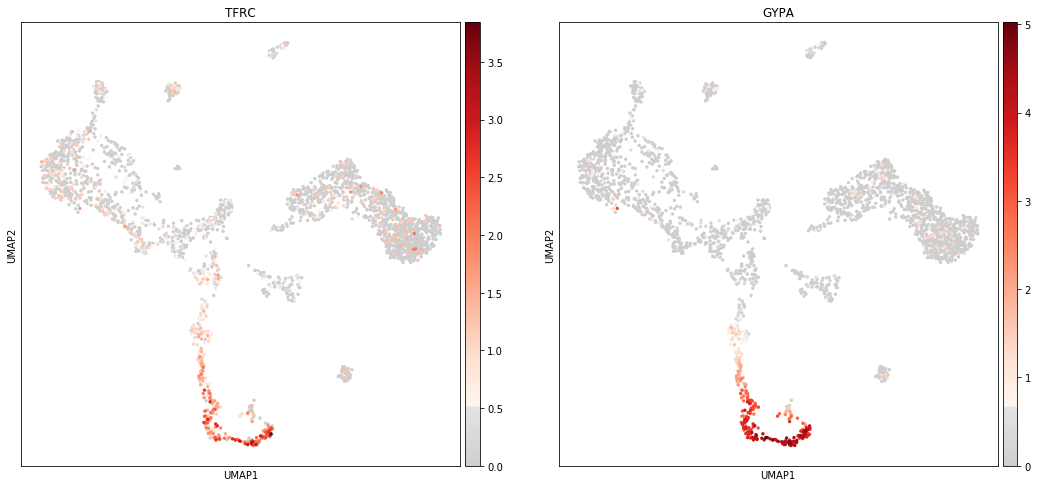

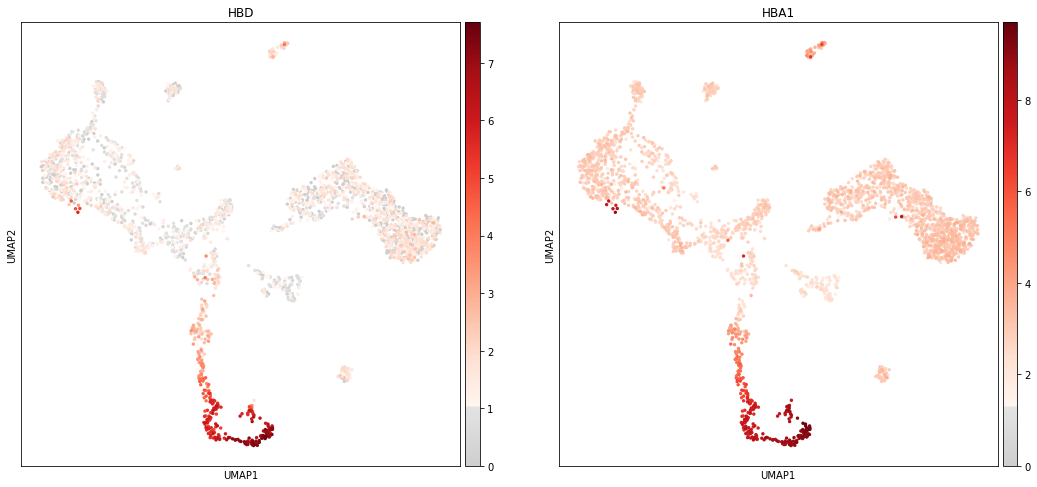

In [145]:
# Erythrocytes progenitors
sc.pl.umap(adata, color=['GATA2'], use_raw=False, color_map=mymap)

# markers from CellMarker (differentiated)
sc.pl.umap(adata, color=['TFRC', 'GYPA'], use_raw=False, color_map=mymap)

# markers from Oetjen and MCA (differentiated)
sc.pl.umap(adata, color=['HBD', 'HBA1'], use_raw=False, color_map=mymap)

## Plasma cells

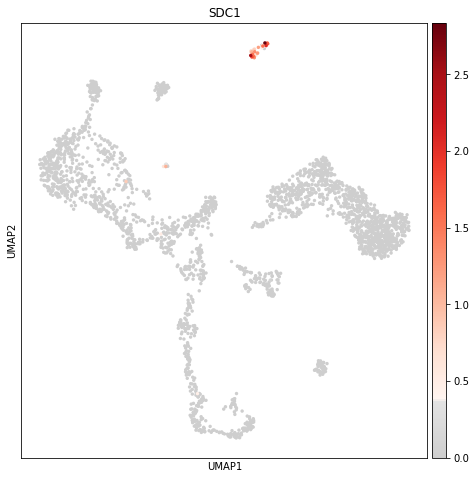

In [86]:
# From CellMarker
sc.pl.umap(adata, color=['SDC1'], use_raw=False, color_map=mymap)

# 6. Subclustering

We subcluster cluster 0 to annotate CD8+ vs CD4+ T cells.

In [101]:
#Subcluster cluster0
sc.tl.louvain(adata, restrict_to=('louvain_r1', ['0']), resolution=0.6, key_added='louvain_r1_sub0')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 19 clusters and added
    'louvain_r1_sub0', the cluster labels (adata.obs, categorical) (0:00:00)


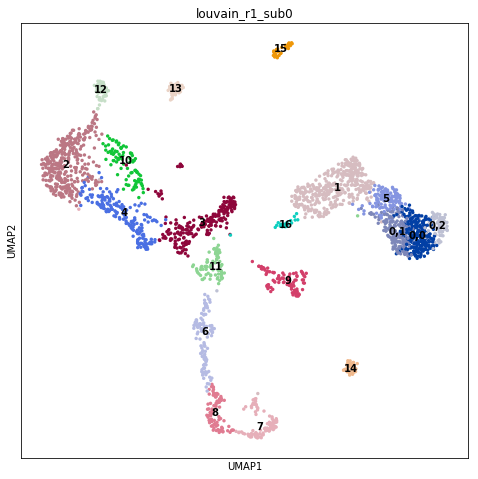

In [103]:
#Show the new clustering
sc.pl.umap(adata, color='louvain_r1_sub0', legend_loc='on data')

# 7. Final cell-type annotation

In [148]:
# Categories to rename
adata.obs['final_annotation'] = adata.obs['louvain_r1_sub0']
adata.rename_categories('final_annotation', ['CD4+ T cells, 1', 'CD4+ T cells, 2', 'CD8+ T cells', 'NKT cells', 'CD14+ Monocytes', 'HSPCs', 'Monocytes progenitors', 'CD4+ T cells, 3', 'Late erythroid progenitors', 'Late erythrocytes', 'Early erythrocytes', 'CD10+ B cells','Monocytes-derived dendritic cells','Early erythroid progenitors', 'CD16+ Monocytes','Plasmacytoid dendritic cells', 'CD20+ B cells', 'Plasma cells', 'NK cells'])

Omitting rank_genes_final/scores as old categories do not match.
Omitting rank_genes_final/names as old categories do not match.
Omitting rank_genes_final/logfoldchanges as old categories do not match.
Omitting rank_genes_final/pvals as old categories do not match.
Omitting rank_genes_final/pvals_adj as old categories do not match.


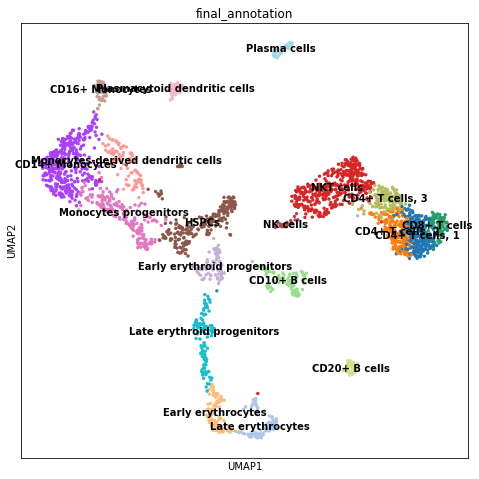

In [149]:
sc.pl.umap(adata, color='final_annotation', legend_loc='on data')

In [150]:
tmp = adata.obs['final_annotation']
tmp = ['CD4+ T cells' if item.startswith('CD4+') else item for item in tmp]
adata.obs['final_annotation'] = tmp

... storing 'final_annotation' as categorical


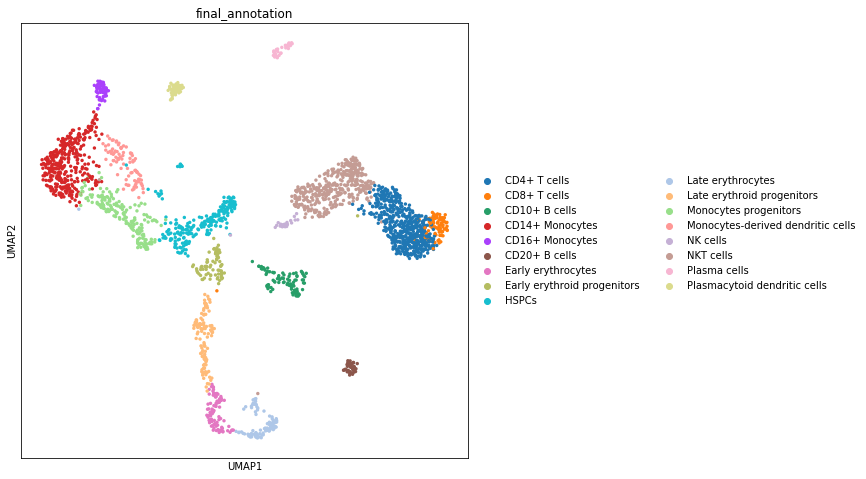

In [151]:
sc.pl.umap(adata, color='final_annotation')

In [152]:
# save final result
adata.write(results_file)

# Erythrocyte differentiation
Here we want to investigate the trajectory of erythrocytes differentiation using PAGA and DPT.

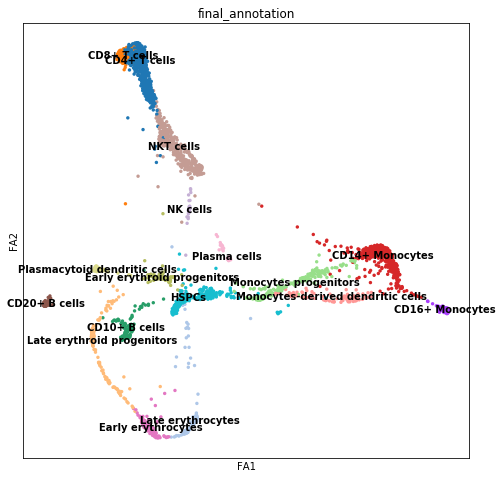

In [153]:
sc.pl.draw_graph(adata, color='final_annotation', legend_loc='on data')

In [154]:
sc.tl.paga(adata, groups='final_annotation')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


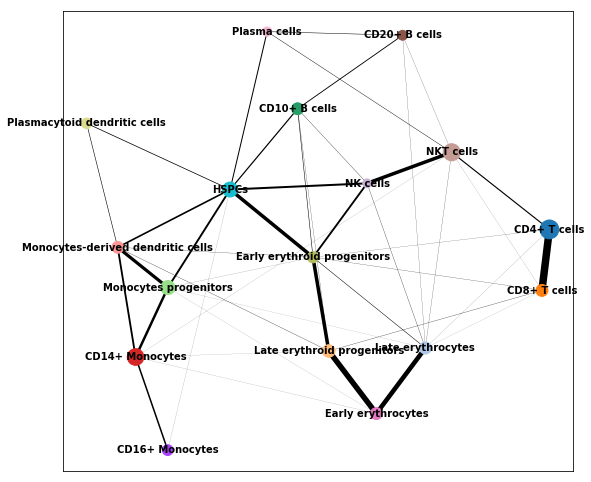

In [155]:
sc.pl.paga(adata, color='final_annotation')

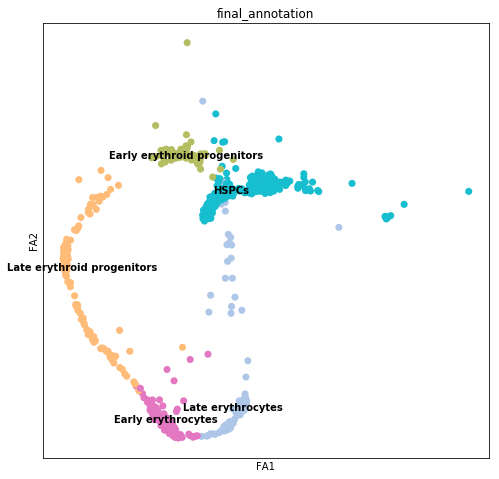

In [156]:
# Subsetting adata to only the clusters included in the trajectory
adata_ery = adata[adata.obs['final_annotation'].isin(['HSPCs','Early erythroid progenitors', 'Late erythroid progenitors', 'Early erythrocytes', 'Late erythrocytes'])]
sc.pl.draw_graph(adata_ery, color='final_annotation', legend_loc='on data')

In [157]:
# Calculate pseudotime with DPT
adata_ery.uns['iroot'] = np.flatnonzero(adata_ery.obs['final_annotation'] == 'HSPCs')[0]
sc.tl.dpt(adata_ery, n_branchings=0, n_dcs=15)

computing Diffusion Pseudotime using n_dcs=15
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


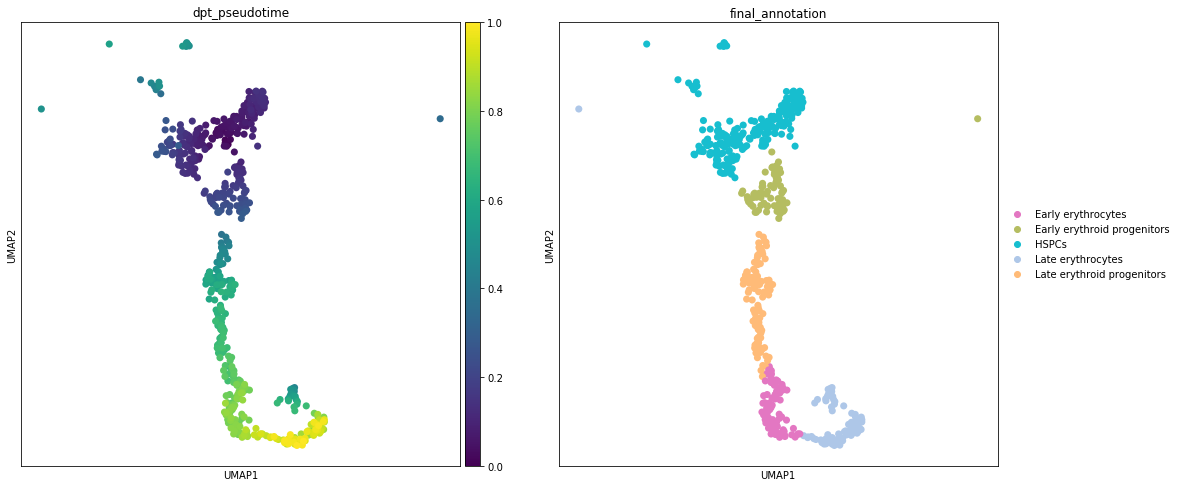

In [159]:
sc.pl.umap(adata_ery, color=['dpt_pseudotime', 'final_annotation'])

In [161]:
# Save ordering of cells in the original adata object

# save adata_ery.obs as a dataframe and make barcodes column accessible
adata_ery_df = adata_ery.obs.reset_index()
adata_ery_df.head()

,barcode,n_counts,log_counts,n_genes,mt_frac,size_factors,louvain_r1,louvain_r0.5,cell_type1,louvain_r1_sub0,final_annotation,dpt_pseudotime
0,AAACGGGCACCTCGGA-1,9227.0,9.129889,2012,0.032080,0.977120,3,3,"Unknown, 1",3,HSPCs,0.000000
1,AAACGGGCACGGATAG-1,17496.0,9.769728,3207,0.043496,2.020745,3,3,"Unknown, 1",3,HSPCs,0.271925
2,AAACGGGGTTTGACTG-1,17467.0,9.768068,3017,0.033148,1.900719,8,4,"Erytro, 3",8,Early erythrocytes,0.708887
3,AACACGTTCCAAACAC-1,13441.0,9.506065,2354,0.030132,1.265456,3,5,"Unknown, 1",3,HSPCs,0.283791
4,AACCGCGTCATCTGTT-1,10151.0,9.225327,1778,0.023544,0.791543,8,4,"Erytro, 3",8,Early erythrocytes,0.763296


In [162]:
# prepare adata_ery_df for merging
adata_ery_df = adata_ery_df[['barcode', 'dpt_pseudotime']]
adata_ery_df.head()

,barcode,dpt_pseudotime
0,AAACGGGCACCTCGGA-1,0.000000
1,AAACGGGCACGGATAG-1,0.271925
2,AAACGGGGTTTGACTG-1,0.708887
3,AACACGTTCCAAACAC-1,0.283791
4,AACCGCGTCATCTGTT-1,0.763296


In [163]:
# save adata.obs as a dataframe and make barcodes column accessible
adata_df = adata.obs.reset_index()
adata_df.head()

,barcode,n_counts,log_counts,n_genes,mt_frac,size_factors,louvain_r1,louvain_r0.5,cell_type1,louvain_r1_sub0,final_annotation
0,AAACCTGCAGCGAACA-1,6379.0,8.760767,1862,0.047970,0.819111,12,9,"Osteocytes, 2",12,CD16+ Monocytes
1,AAACCTGCATGTCCTC-1,4172.0,8.336151,1082,0.024928,0.362335,0,0,"T cells, 1","0,0",CD4+ T cells
2,AAACCTGGTCGACTGC-1,6608.0,8.796037,1618,0.051907,0.664294,2,2,"Monocytes, 1",2,CD14+ Monocytes
3,AAACCTGGTCGCTTCT-1,5034.0,8.523971,1413,0.041716,0.552547,2,2,"Monocytes, 1",2,CD14+ Monocytes
4,AAACCTGTCCCGACTT-1,3998.0,8.293550,1127,0.043522,0.406517,1,1,"T+NK, 1",1,NKT cells


In [164]:
# merge the two dataframes
adata_merge = adata_df.merge(adata_ery_df, how='left', on='barcode')
adata_merge.head()

,barcode,n_counts,log_counts,n_genes,mt_frac,size_factors,louvain_r1,louvain_r0.5,cell_type1,louvain_r1_sub0,final_annotation,dpt_pseudotime
0,AAACCTGCAGCGAACA-1,6379.0,8.760767,1862,0.047970,0.819111,12,9,"Osteocytes, 2",12,CD16+ Monocytes,NaN
1,AAACCTGCATGTCCTC-1,4172.0,8.336151,1082,0.024928,0.362335,0,0,"T cells, 1","0,0",CD4+ T cells,NaN
2,AAACCTGGTCGACTGC-1,6608.0,8.796037,1618,0.051907,0.664294,2,2,"Monocytes, 1",2,CD14+ Monocytes,NaN
3,AAACCTGGTCGCTTCT-1,5034.0,8.523971,1413,0.041716,0.552547,2,2,"Monocytes, 1",2,CD14+ Monocytes,NaN
4,AAACCTGTCCCGACTT-1,3998.0,8.293550,1127,0.043522,0.406517,1,1,"T+NK, 1",1,NKT cells,NaN


In [165]:
# reassign merged dataframe as adata.obs
adata_merge.set_index('barcode', inplace = True)
adata.obs = adata_merge

In [166]:
# save final result
adata.write(results_file)